# Sheet 2

The purpose of this sheet is to get acquainted with the solution of linear systems using elementary methods. As a model problem, we will work with polynomial interpolation. We will also use this homework as an opportunity to examine and familiarize ourselves with the Numpy library for Python, which makes it extremely easy to work with arrays in general, and vectors and matrices in particular.

---

<div class="alert alert-info">

### NumPy and Linear Algebra in Python

</div>

There are several excellent sources of documentation for Numpy.

<div class="alert alert-success">
    
**Task 1:** Familiarize yourself with Numpy by reading the [quickstart tutorial](https://docs.scipy.org/doc/numpy/user/quickstart.html):
- In particular, since we will be working with matrices (two-dimensional arrays), make sure you understand indexing and slicing.
- Also, be aware of the semantics of assignments (view vs. copy), which is sometimes tricky for beginners. More [here](https://www.jessicayung.com/numpy-views-vs-copies-avoiding-costly-mistakes/) and [here](https://scipy-cookbook.readthedocs.io/items/ViewsVsCopies.html).
</div>

Let's get started by importing the relevant packages and doing some basic setup.


In [8]:
import numpy as np              # basic arrays, vectors, matrices
import numpy.linalg as la       # linear algebra functions
import matplotlib.pyplot as plt # plotting

%matplotlib inline

---

<div class="alert alert-info">

### Polynomial Interpolation

</div>

_Interpolation_ refers to the process of extrapolating from discrete measurements to a continuous function. A model problem is for example to compute the continuous trajectory $x(t)$ of an object over time from discrete snapshots $(t_i,x_i)$. _Polynomial interpolation_ specifically refers to describing the continuous function as a polynomial.

Formally, the (one-dimensional) polynomial interpolation problem is described as follows: given a sequence of $n$ $x$-coordinates $(x_0,\dots,x_n)$ with $x_i \neq x_j$ if $i\neq j$ and corresponding values $y_i \in \mathbb{R}$, determine a polynomial $p(x)$ of degree $n$ such that

$$
p(x_i)\ =\ a_n x^n + a_{n-1} x^{n-1} + \cdots + a_1 x + a_0\ \stackrel{!}{=}\ y_i,\ \ i=0,\dots,n.
$$

This problem can be turned into a linear system, as follows:

Let $v_j$ the vector of powers of $v_j$, i.e.

$$v_j = (1, x_j, x_j^2, \dots, x_j^n)^T,$$

and let $a = (a_0, a_1, \dots, a_n)^T$ the vector of coefficients of $p$. Then, the interpolation condition $p(x_i) = y_i$ can be written as the scalar product of $q_i$ and $a$, since

$$
p(x_i)\ =\ a_n x_i^n + \cdots + a_1 x_i + 1 \cdot a_0 = \ a^T v_i\  \stackrel{!}{=} y_i
$$

Repeating this for $i=0,\dots,n$, we obtain a linear system for the coefficients:

$$
\begin{pmatrix}
1 & x_0 & x_0^2 & \cdots & x_0^n \\
1 & x_1 & x_1^2 & \cdots & x_1^n \\
1 & x_2 & x_2^2 & \cdots & x_2^n \\
\vdots & \vdots &\vdots &\vdots & \\
1 & x_n & x_n^2 & \cdots & x_n^n \\
\end{pmatrix}
\begin{pmatrix} a_0 \\ a_1 \\ a_2 \\ \vdots \\ a_n\end{pmatrix} =
\begin{pmatrix} y_0 \\ y_1 \\ y_2 \\ \vdots \\ y_n\end{pmatrix}
\qquad
$$

or briefly using matrix notation

$$V a = y$$

The $(n+1)\times (n+1)$ system matrix $V$ with $V_{ij} = x_i^j$ is called a _Vandermonde matrix_. A solution of the corresponding system gives the coefficients $a$ of the polynomial $p$.

Let's consider a specific problem instance: first, define NumPy arrays containing the data $x_i$ and $y_i$:


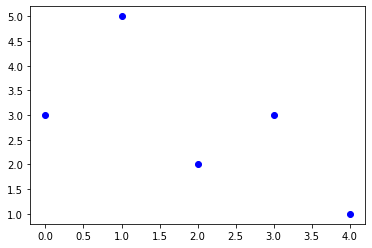

In [9]:
n = 4
y = np.array( [3., 5, 2, 3, 1] )
x = np.array( [0., 1, 2, 3, 4] )

plt.plot( x, y, 'bo' );

Graphically, our goal is to construct a polynomial of degree $4$ (since there are five points) that exactly passes through these points.

(You have encountered this problem previously when constructing a line (= polynomial of degree one) given two points, or a parabola (= polynomial of degree two) that passes through three given points.

We begin by constructing the Vandermonde system matrix for the $x_i$. Naively, we would write


In [10]:
V = np.empty( (n+1, n+1) )

# directly fill in matrix entries
for i in range(n+1):
    for j in range(n+1):
        V[i,j] = x[i]**j
        
V

array([[  1.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.,  16.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

However, we can write this a little more compactly using a list comprehension:


In [11]:
# create a 2D array whose rows are the powers of x,
# then transpose so the columns are the powers of x
V = np.array( [x**p for p in range(n+1)] )
V

array([[  1.,   1.,   1.,   1.,   1.],
       [  0.,   1.,   2.,   3.,   4.],
       [  0.,   1.,   4.,   9.,  16.],
       [  0.,   1.,   8.,  27.,  64.],
       [  0.,   1.,  16.,  81., 256.]])

Even shorter: NumPy directly offers the [`vander`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vander.html) function for constructing $V$. By default, `vander` constructs the matrix such that the powers decrease along the rows of $V$; we thus need to pass `increasing=True` to match the order of $a$ we defined above.


In [12]:
V = np.vander( x, increasing=True )
V

array([[  1.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.,  16.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

Now we can solve the system $Va = y$ for $a$ to obtain the coefficients of the polynomial $p$.


---

<div class="alert alert-info">
    
### Gauss Elimination
</div>

The Gauss elimination algorithm can be used to solve the system above.


<div class="alert alert-success">
    
**Task 2:** Implement the Gauss algorithm (without pivoting) in two steps through the below functions:
- `bwd_subs` should perform backward substitution to solve an upper tridiagonal system
- `gauss_solve` should reduce the extended matrix $(A,b)$ to upper tridiagonal form via Gauss elimination, and then use `bwd_subs` to solve the system
- It is always sensible to think about ways to validate your implementations, e.g. check that `bwd_subs` does the right thing.
</div>


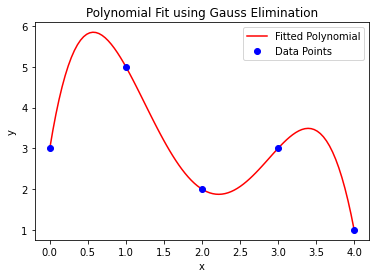

In [13]:
import numpy as np

def bwd_subs(U, y):
    """Solve the linear system Ux = y with upper triangular matrix U by backward substitution."""
    n = U.shape[0]
    x = np.zeros(n)
    
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
    
    return x


def gauss_solve(A, b):
    """Solve the linear system Ax=b using direct Gaussian elimination and backward substitution."""
    n = len(b)
    # Create an augmented matrix
    Ab = np.hstack([A, b.reshape(-1, 1)])
    
    # Gaussian elimination process
    for i in range(n):
        # Normalize the pivot row
        Ab[i] = Ab[i] / Ab[i, i]
        for j in range(i+1, n):
            Ab[j] = Ab[j] - Ab[i] * Ab[j, i]
    
    # Separate the upper triangular matrix U and the modified vector b
    U = Ab[:, :-1]
    y = Ab[:, -1]
    
    # Perform backward substitution
    x = bwd_subs(U, y)
    
    return x


# Define the Vandermonde matrix V and the vector y
V = np.vander(x, increasing=True)  # Vandermonde matrix

# Solve the system using the implemented Gauss elimination function
a = gauss_solve(V, y)

# Generate points for plotting the polynomial
xx = np.linspace(x.min(), x.max(), 100)
yy = np.polyval(np.flip(a), xx)

# Plot the polynomial and the original points
plt.plot(xx, yy, 'r-', label='Fitted Polynomial')
plt.plot(x, y, 'bo', label='Data Points')
plt.legend()
plt.title("Polynomial Fit using Gauss Elimination")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


Let's apply this to our problem and validate the solution graphically. NumPy conveniently provides the [`polyval`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyval.html) function to evaluate the found polynomial.

A potential showstopper is that `polyval` requires as input the coefficients in descending order (i.e. `a[0]` as the coefficient of $x^n$), while we compute them in ascending order (`a[n]` is the coefficient of $x^n$). This is however easily remedied using NumPy's [`flip`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.flip.html?highlight=flip#numpy.flip) function.


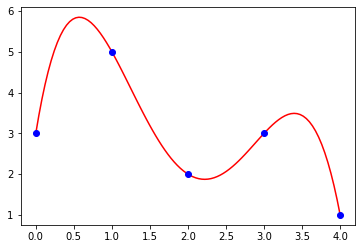

In [14]:
a = gauss_solve( V, y )

y = np.array( [3., 5, 2, 3, 1] )
x = np.array( [0., 1, 2, 3, 4] )
# plot output
xx = np.linspace( x.min(), x.max(), 100 )
yy = np.polyval( np.flip(a), xx )


plt.plot( xx, yy, 'r-', x, y, 'bo' );

Problem solved!


---

<div class="alert alert-info">
    
### LU Decomposition
</div>

While Gauss elimination works well for a small number of points, for a large number of points it does not work well. Let's look at a larger problem instance:


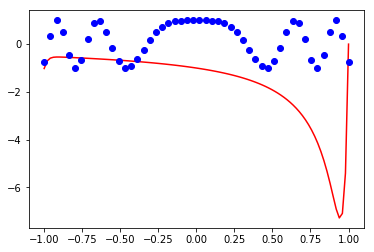

In [8]:
n = 50
x = np.linspace( -1, 1, n )
y = np.cos( 15*x**2 )

# set up system matrix
V = np.vander( x, increasing=True )
a = gauss_solve( V, y )

# plot output
x = np.linspace( -1, 1, n )
y = np.cos( 15*x**2 )
xx = np.linspace( x.min(), x.max(), 100 )
yy = np.polyval( np.flip(a), xx )

plt.plot( xx, yy, 'r-', x, y, 'bo' );

This does not look entirely right. In order to quantify the error, we can compute the norm of the _residual_ vector:

$$r := y - Va $$


In [9]:
la.norm(y- np.matmul(V, a))

17.752303108487546

and see that it is not actually small.

The reason that the residual is so large lies in the ill-conditioned nature of the system matrix. NumPy gives us an easy way to compute the condition number of the system matrix, which indicates how much small errors are amplified when solving the system:


In [10]:
la.cond( V )

4.548112917510645e+18

That is a big number. While the Gauss algorithm works well for well-conditioned problems, it is not stable enough to address severely ill-conditioned problems; hence it does not work well here.

**Aside**: It is easy to see that the condition number increases rapidly with $n$:


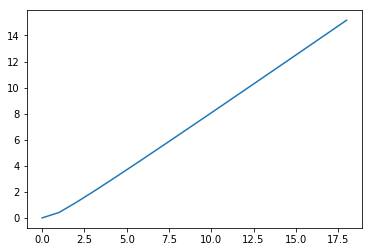

In [11]:
plt.plot( [np.log10(la.cond(np.vander(np.linspace(0,1,n)))) for n in range(1,20)] );

As the number of points increases, the columns of the Vandermonde matrix become more and more similar and thus less and less linear independent; for 10 points, the condition number is already $\approx 10^8$. In a sense, the system becomes more and more difficult to solve, leading to increasing problems in the application of numerical techniques. (This is quite typical behavior for many important numerical problems / techniques.)

To remedy this, let's apply the LU decomposition with partial pivoting to solve this system. The purpose of the pivoting is to increase the numerical stability of the algorithm.

<div class="alert alert-success">

**Task 3**: implement routines `lu_factor`, `fwd_subs` and `lu_solve` below for computing and using the LU decomposition with partial pivoting

</div>


In [15]:
import numpy as np

def lu_factor(A):
    """Perform an LU decomposition PA = LU with partial pivoting of the square matrix A."""
    n = A.shape[0]
    P = np.eye(n)  # Identity matrix for permutations
    L = np.zeros_like(A)
    U = A.copy()
    
    for i in range(n):
        # Partial pivoting
        max_index = np.argmax(np.abs(U[i:, i])) + i
        if i != max_index:
            U[[i, max_index], :] = U[[max_index, i], :]
            P[[i, max_index], :] = P[[max_index, i], :]
            if i > 0:
                L[[i, max_index], :i] = L[[max_index, i], :i]
        
        # LU decomposition
        L[i, i] = 1
        for j in range(i+1, n):
            L[j, i] = U[j, i] / U[i, i]
            U[j, :] -= L[j, i] * U[i, :]
    
    return P, L, U


def fwd_subs(L, b):
    """Solve the linear system Ly = b with lower triangular matrix L by forward substitution."""
    n = L.shape[0]
    y = np.zeros_like(b)
    
    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])
    
    return y


def lu_solve(P, L, U, b):
    """Solve the linear system Ax = b with upper/lower triangular matrices U, L and permutation matrix P."""
    # Apply permutation to b
    Pb = np.dot(P, b)
    
    # Forward substitution to solve Ly = Pb
    y = fwd_subs(L, Pb)
    
    # Backward substitution to solve Ux = y
    x = bwd_subs(U, y)
    
    return x

    

Let's apply this to our problem:


Residual = 1.122806381965036e-09


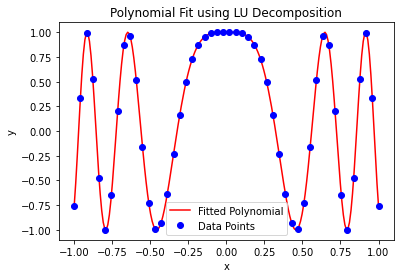

In [16]:
import numpy.linalg as la
import matplotlib.pyplot as plt

# Define the problem
n = 50
x = np.linspace(-1, 1, n)
y = np.cos(15 * x**2)

# Set up the system matrix
V = np.vander(x, increasing=True)

# Perform LU decomposition
P, L, U = lu_factor(V)
a = lu_solve(P, L, U, y)

# Compute the residual
residual = la.norm(y - np.matmul(V, a))
print("Residual =", residual)

# Plot the output
xx = np.linspace(x.min(), x.max(), 200)
yy = np.polyval(np.flip(a), xx)

plt.plot(xx, yy, 'r-', label='Fitted Polynomial')
plt.plot(x, y, 'bo', label='Data Points')
plt.legend()
plt.title("Polynomial Fit using LU Decomposition")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


---

<div class="alert alert-info">

### Microbenchmarks

</div>

Beyond numerical stability from pivoting, the LU decomposition also has one other advantage: the elimination work is captured in $L$ and $U$ and does not have to be repeated if the same linear system must be solved repeatedly for different right-hand sides.

This is a good opportunity to use a _microbenchmark_ to quickly get an idea whether this is true in practice. Let's create one using Jupyter's [`%%timeit`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) magic that measures the runtime of a single cell. First, set up a test problem, using again polynomial interpolation:


In [26]:
n = 40
x = np.linspace( 0, 1, n )

# set up the system matrix
V = np.vander( x, increasing=True )

# create m random right-hand sides
m = 500
y = np.random.random(size=(m,n))
print(y)

[[0.84973848 0.51766726 0.06218072 ... 0.43255302 0.56369251 0.30812977]
 [0.82160348 0.94723854 0.46624034 ... 0.52994    0.96817653 0.92075758]
 [0.73393522 0.59441446 0.93126784 ... 0.82908136 0.60030895 0.50795598]
 ...
 [0.48199522 0.45168793 0.3321834  ... 0.32483888 0.21414574 0.97760239]
 [0.35151742 0.15481323 0.89341336 ... 0.4687913  0.20871441 0.33832555]
 [0.00272127 0.78823174 0.34020785 ... 0.04924555 0.93547787 0.29931606]]


Now, we can measure the time required to do one decomposition and $m$ solutions:


In [27]:
%%timeit

P,L,U = lu_factor(V)
for b in y:
    a = lu_solve(P,L,U, b)

123 ms ± 8.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<div class="alert alert-success">

**Task 4**: create a microbenchmark that uses `gauss_solve` to solve the system for each right-hand side.

</div>


In [32]:
import timeit
import numpy as np

# Problem setup
n = 40
x = np.linspace(0, 1, n)

# Set up the system matrix (Vandermonde matrix)
V = np.vander(x, increasing=True)

# Create m random right-hand sides
m = 500
y = np.random.random(size=(m, n))

# Define a function to benchmark gauss_solve
def benchmark_gauss_solve():
    for b in y:
        a = gauss_solve(V, b)

# Measure the time taken
execution_time = timeit.timeit(benchmark_gauss_solve, number=1)
print(f"Time taken by gauss_solve for {m} right-hand sides: {execution_time:.6f} seconds")


Time taken by gauss_solve for 500 right-hand sides: 1.152019 seconds


Depending on your implementation, the LU decomposition should be significantly faster on this particular problem.

Note: this is not a rigorous benchmark; it may be influenced by many factors such as overall system load etc. However, `%%timeit` can be useful to get a quick idea of execution time. (See the [documentation](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) for more info.)

**Concluding remark**: While it was instructive for the purposes of this homework to implement Gauss elimination and LU decomposition by ourselves, for real-world use, NumPy's linear algebra module offers the routine [`numpy.linalg.solve`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html), which is a state-of-the-art linear system solver with many tricks to improve numerical stability. Furthermore, the `scipy` module contains implementations of the LU(P) decomposition (cf. [`scipy.linalg.lu`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.lu.html)).
